### Función para generar la población

#### Nueva función PC1

In [17]:
# Cargar librerías necesarias
library(survey)

PC_Estimator <- function(data,
                         y_A_col = NULL,          # Nombre de la variable objetivo en S_A
                         y_B_col = NULL,          # Nombre de la variable objetivo en S_B (debe ser NULL para Escenario 2)
                         sample_A_col,            # Indicador de pertenencia a S_A
                         sample_B_col,            # Indicador de pertenencia a S_B
                         aux_vars,                # Variables auxiliares para calibración
                         pop_totals,              # Totales poblacionales de variables auxiliares (vector numérico nombrado)
                         N_total,
                         initial_weight = NULL,   # Peso inicial para S_B
                         weights_B_col = NULL,    # Nombre de la columna de pesos iniciales para S_B
                         weights_A_col = NULL,    # Nombre de la columna de pesos para S_A
                         pred_vars = NULL,        # Variables para el modelo de predicción
                         model_type = "normal",   # Tipo de modelo de predicción ("normal", "logistic")
                         scenario = 1,
                         eval_model_performance = FALSE  # Evaluar la performance del modelo
                         ) {
    # Verificación de la validez del escenario
    if (!scenario %in% c(1, 2, 3)) {
        stop("El 'scenario' debe ser 1, 2 o 3.")
    }
    
    # Subconjunto de datos para S_B y S_A
    data_S_B <- subset(data, data[[sample_B_col]] == 1)
    n_B <- nrow(data_S_B)
    
    data_S_A <- subset(data, data[[sample_A_col]] == 1)
    n_A <- nrow(data_S_A)
    
    if (n_B == 0) stop("No hay unidades en la muestra S_B.")
    if (n_A == 0) stop("No hay unidades en la muestra S_A.")
    
    # Asignar pesos iniciales para S_B
    if (!is.null(weights_B_col)) {
        data_S_B$d_i_B <- data_S_B[[weights_B_col]]
    } else if (is.null(initial_weight)) {
        data_S_B$d_i_B <- N_total / n_B
    } else if (is.numeric(initial_weight)) {
        data_S_B$d_i_B <- initial_weight
    } else if (initial_weight == "uniform") {
        data_S_B$d_i_B <- 1
    } else {
        stop("initial_weight debe ser numérico o 'uniform'.")
    }
    
    # Asignar pesos para S_A
    if (!is.null(weights_A_col)) {
        data_S_A$d_i_A <- data_S_A[[weights_A_col]]
    } else {
        data_S_A$d_i_A <- N_total / n_A
    }
    
    # Crear fórmula de calibración
    calibration_formula <- as.formula(paste("~0 +", paste(aux_vars, collapse = " + ")))
    
    # Calibrar pesos para S_B
    design_S_B <- svydesign(ids = ~1, data = data_S_B, weights = ~d_i_B)
    calibrated_design_S_B <- tryCatch({
        calibrate(
            design = design_S_B,
            formula = calibration_formula,
            population = pop_totals,
            calfun = "linear"
        )
    }, error = function(e) {
        stop("Error en la calibración de pesos: ", e$message)
    })
    weights_calibrated_B <- weights(calibrated_design_S_B)
    
    if (scenario == 1) {
        # Escenario 1: Variable objetivo observada en S_B
        if (is.null(y_B_col)) {
            stop("Para el Escenario 1, 'y_B_col' no puede ser NULL.")
        }
        mean_PC <- svymean(as.formula(paste("~", y_B_col)), calibrated_design_S_B)
        est_mean_PC <- coef(mean_PC)
        SE_PC <- SE(mean_PC)
        
        return(list(
            estimator = est_mean_PC,
            SE = SE_PC,
            weights_B = weights_calibrated_B
        ))
        
    } else if (scenario == 2) {
        # Escenario 2: Variable objetivo no observada en S_B, se necesita predecir y_i
        if (is.null(pred_vars)) stop("Debe proporcionar 'pred_vars' para el modelo de predicción.")
        if (is.null(y_A_col)) stop("Debe proporcionar 'y_A_col' para el modelo de predicción.")
        
        # Construir el modelo de predicción utilizando únicamente S_A
        if (model_type == "normal") {
            prediction_formula <- as.formula(paste(y_A_col, "~", paste(pred_vars, collapse = " + ")))
            model <- lm(prediction_formula, data = data_S_A)
        } else if (model_type == "logistic") {
            prediction_formula <- as.formula(paste(y_A_col, "~", paste(pred_vars, collapse = " + ")))
            model <- glm(prediction_formula, data = data_S_A, family = binomial)
        } else {
            stop("model_type debe ser 'normal' o 'logistic'.")
        }
        
        # Predecir y_i en S_B
        if (model_type == "normal") {
            data_S_B$hat_y_i <- predict(model, newdata = data_S_B, type = "response")
        } else if (model_type == "logistic") {
            data_S_B$hat_y_i <- predict(model, newdata = data_S_B, type = "response")
        }
        
        # Predecir y_i en S_A y calcular residuos
        if (model_type == "normal") {
            data_S_A$hat_y_i <- predict(model, newdata = data_S_A, type = "response")
        } else if (model_type == "logistic") {
            data_S_A$hat_y_i <- predict(model, newdata = data_S_A, type = "response")
        }
        data_S_A$residuals <- data_S_A[[y_A_col]] - data_S_A$hat_y_i
        
        # Calcular el estimador PC
        term1 <- sum(weights_calibrated_B * data_S_B$hat_y_i)
        term2 <- sum(data_S_A$d_i_A * data_S_A$residuals)
        estimator_PC <- (term1 + term2) / N_total  # Dividir por N para obtener la media
        
        return(list(
            estimator = estimator_PC,
            weights_B = weights_calibrated_B,
            model = model
        ))
        
    } else if (scenario == 3) {
        # Escenario 3: Violación del supuesto MAR, implementar estimador DR1
        if (is.null(pred_vars)) stop("Debe proporcionar 'pred_vars' para el modelo de predicción.")
        if (is.null(y_A_col)) stop("Debe proporcionar 'y_A_col' para el modelo de predicción.")
        if (is.null(y_B_col)) stop("Para el Escenario 3, 'y_B_col' no puede ser NULL.")
        
        # Construir el modelo de predicción utilizando únicamente S_A
        if (model_type == "normal") {
            prediction_formula <- as.formula(paste(y_A_col, "~", paste(pred_vars, collapse = " + ")))
            model <- lm(prediction_formula, data = data_S_A)
        } else if (model_type == "logistic") {
            prediction_formula <- as.formula(paste(y_A_col, "~", paste(pred_vars, collapse = " + ")))
            model <- glm(prediction_formula, data = data_S_A, family = binomial)
        } else {
            stop("model_type debe ser 'normal' o 'logistic'.")
        }
        
        # Predecir y_i en S_B
        data_S_B$hat_y_i <- predict(model, newdata = data_S_B, type = "response")
        
        # Predecir y_i en la población completa
        if (!"hat_y_i" %in% names(data)) {
            data$hat_y_i <- predict(model, newdata = data, type = "response")
        }
        sum_hat_y_U <- sum(data$hat_y_i, na.rm = TRUE)
        
        # Calcular los residuos en S_A
        data_S_A$hat_y_i <- predict(model, newdata = data_S_A, type = "response")
        data_S_A$residuals <- data_S_A[[y_A_col]] - data_S_A$hat_y_i
        
        # Calcular el estimador DR1
        term1_DR1 <- sum(weights_calibrated_B * (data_S_B[[y_B_col]] - data_S_B$hat_y_i))
        estimator_DR1 <- (term1_DR1 + sum_hat_y_U) / N_total  # Dividir por N para obtener la media
        
        # Evaluar el rendimiento del modelo (opcional)
        if (eval_model_performance) {
            # Calcular el RMSE en S_A
            RMSE <- sqrt(mean(data_S_A$residuals^2))
            
            # Calcular el R^2
            SST <- sum((data_S_A[[y_A_col]] - mean(data_S_A[[y_A_col]]))^2)  # Suma total de cuadrados
            SSR <- sum(data_S_A$residuals^2)  # Suma de residuos al cuadrado
            R2 <- 1 - (SSR / SST)
            
            return(list(
                estimator_DR1 = estimator_DR1,
                weights_B = weights_calibrated_B,
                model = model,
                RMSE = RMSE,
                R2 = R2
            ))
        } else {
            return(list(
                estimator_DR1 = estimator_DR1,
                weights_B = weights_calibrated_B,
                model = model
            ))
        }
    } else {
        stop("Escenario inválido. Debe ser 1, 2 o 3.")
    }
}


### Población

Correlaciones para gamma_y = -1 :
              x1_i          x2_i         x3_i          x4_i          x5_i
x1_i  1.0000000000 -0.0023933612 -0.001659489  6.727438e-01 -6.632887e-04
x2_i -0.0023933612  1.0000000000  0.003074717  3.097910e-01 -4.188138e-04
x3_i -0.0016594888  0.0030747172  1.000000000 -1.562925e-03  4.971752e-01
x4_i  0.6727438479  0.3097909594 -0.001562925  1.000000e+00  7.650905e-05
x5_i -0.0006632887 -0.0004188138  0.497175180  7.650905e-05  1.000000e+00
y_i   0.7648308860 -0.4909991931 -0.177754808  3.628358e-01 -8.818131e-02
             y_i
x1_i  0.76483089
x2_i -0.49099919
x3_i -0.17775481
x4_i  0.36283580
x5_i -0.08818131
y_i   1.00000000


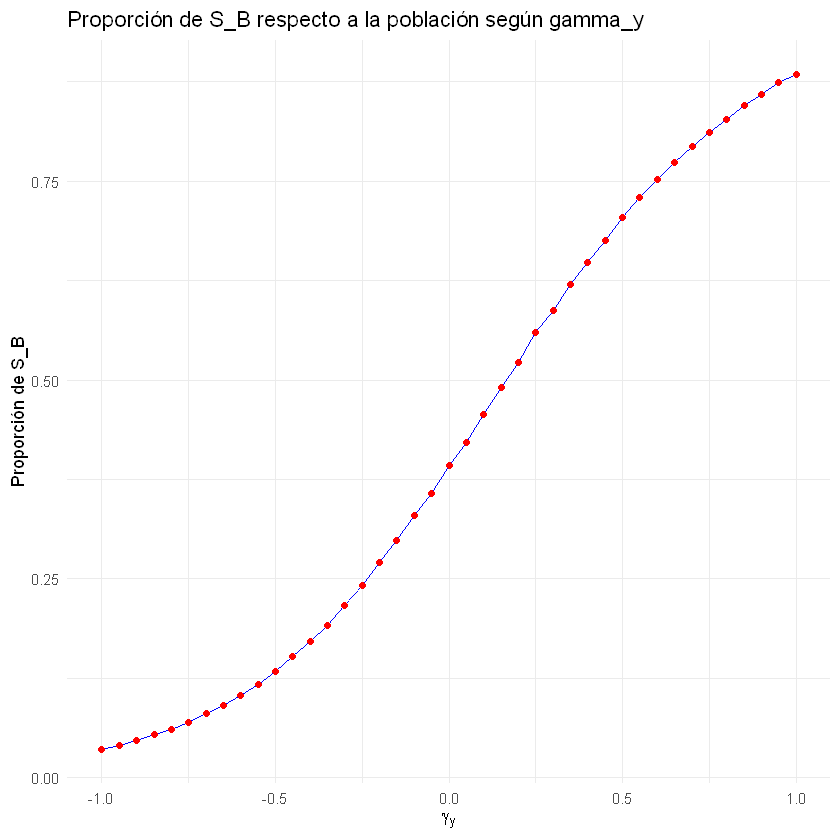

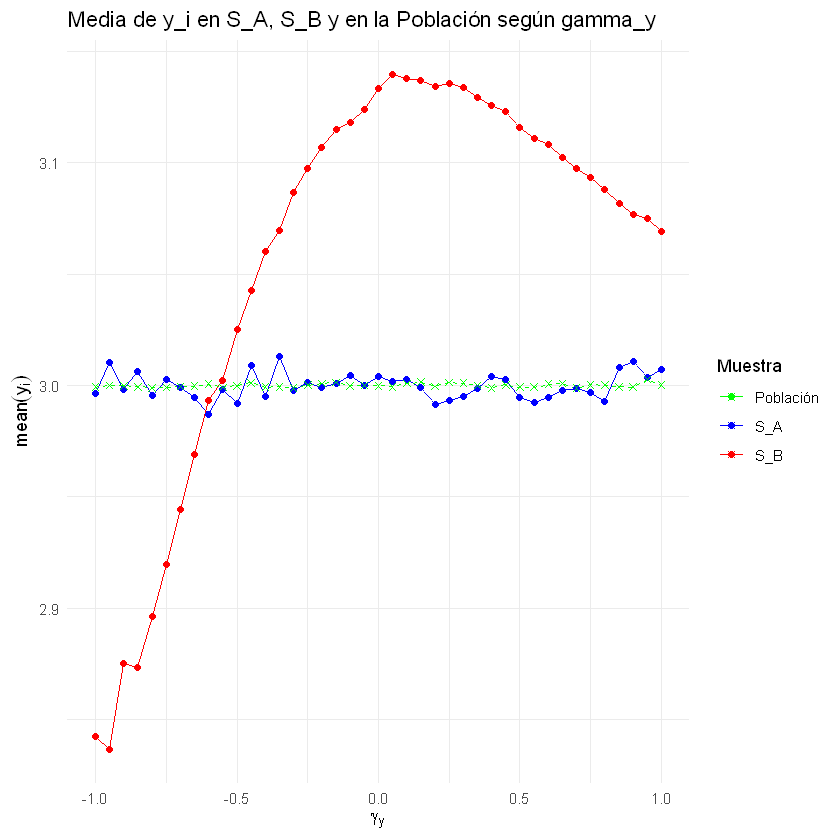

In [19]:
simulate_population <- function(gamma_y = 0,          # Coeficiente para y_i en pi_B
                                sample_size_A = 1000,  # Tamaño de la muestra probabilística S_A
                                N = 100000,            # Tamaño de la población
                                seed = 123,            # Semilla para reproducibilidad
                                target_proportion_Sb = 0.5) {  # Proporción deseada para S_B
    
    set.seed(seed)  # Establecer semilla para reproducibilidad
    
    # 1. Generar covariables principales con correlaciones más fuertes
    x1_i <- rnorm(N, mean = 2, sd = 1)          # Variable continua
    x2_i <- rbinom(N, size = 1, prob = 0.3)     # Variable binaria
    x3_i <- runif(N, min = 1, max = 3)         # Variable continua adicional con distribución uniforme
    
    # 2. Generar covariables adicionales débilmente relacionadas
    x4_i <- 0.5 * x1_i + 0.5 * x2_i + rnorm(N, mean = 0, sd = 0.5)  # Aumentar correlación con x1_i, x2_i
    x5_i <- 0.5 * x3_i + rnorm(N, mean = 0, sd = 0.5)               # Aumentar correlación con x3_i
    
    # 3. Definir coeficientes para y_i
    b1 <- 0.5   # Coeficiente para x1_i
    b2 <- -0.7   # Coeficiente para x2_i
    b3 <- -0.2    # Coeficiente para x3_i
    
    # Calcular el intercepto para que E[y_i] = 3
    mean_x1 <- mean(x1_i)
    mean_x2 <- mean(x2_i)
    mean_x3 <- mean(x3_i)
    
    a <- 3 - (b1 * mean_x1) - (b2 * mean_x2) - (b3 * mean_x3)
    
    # Generar el error aleatorio con menor variabilidad para fortalecer la relación
    eta_i <- rnorm(N, mean = 0, sd = 0.25)  # Reducir el ruido para aumentar correlaciones
    
    # Calcular y_i con mayores coeficientes para aumentar las correlaciones
    y_i <- a + b1 * x1_i + b2 * x2_i + b3 * x3_i + eta_i
    
    # 5. Calcular la probabilidad de inclusión pi_B
    gamma_0 <- -3
    gamma_1 <- 0.5
    gamma_2 <- -0.3
    gamma_3 <- 0.8  # Coeficiente para x3_i
    
    # Cálculo del predictor lineal
    linear_predictor <- gamma_0 + 
                        gamma_1 * x1_i + 
                        gamma_2 * x2_i + 
                        gamma_3 * x3_i + 
                        gamma_y * y_i
    
    # Nuevo término de ajuste basado en la proporción deseada
    adjustment_term <- log(target_proportion_Sb / (1 - target_proportion_Sb))
    
    # Calcular pi_B ajustada
    pi_B <- exp(linear_predictor + adjustment_term) / (1 + exp(linear_predictor + adjustment_term))
    pi_B <- pmin(pmax(pi_B, 0), 1)
    
    # 6. Seleccionar la muestra no probabilística S_B
    u_i <- runif(N, min = 0, max = 1)
    S_B <- ifelse(u_i < pi_B, 1, 0)
    
    # 7. Seleccionar la muestra probabilística S_A mediante SRS
    indices_A <- sample(1:N, size = sample_size_A, replace = FALSE)
    S_A <- rep(0, N)
    S_A[indices_A] <- 1
    
    # 8. Crear el data.frame de la población
    poblacion <- data.frame(
      id = 1:N,
      x1_i = x1_i,
      x2_i = x2_i,
      x3_i = x3_i,
      x4_i = x4_i,
      x5_i = x5_i,
      y_i = y_i,
      S_A = S_A,
      S_B = S_B
    )
    
    return(poblacion)
}


# Definir una secuencia de valores para gamma_y
gamma_y_values <- seq(-1, 1, by = 0.05)

# Inicializar listas para almacenar resultados
correlations_list <- list()   # Almacenar correlaciones
proportion_Sb_list <- numeric(length(gamma_y_values))  # Proporción de S_B
mean_A_list <- numeric(length(gamma_y_values))  # Media de S_A
mean_Sb_list <- numeric(length(gamma_y_values))  # Media de S_B
mean_population_list <- numeric(length(gamma_y_values))  # Media de la población

# Definir parámetros fijos
sample_size_A <- 10000
N <- 100000
base_seed <- 123  # Semilla base para reproducibilidad

# Bucle para simular para cada valor de gamma_y
for (i in seq_along(gamma_y_values)) {
    gamma <- gamma_y_values[i]
    poblacion <- simulate_population(gamma_y = gamma, 
                                     sample_size_A = sample_size_A, 
                                     N = N, 
                                     seed = base_seed + i)
    
    # 1. Calcular la correlación entre todas las variables y la variable de respuesta (y_i)
    correlations <- cor(poblacion[, c("x1_i", "x2_i", "x3_i", "x4_i", "x5_i", "y_i")])
    correlations_list[[as.character(gamma)]] <- correlations
    
    # 2. Calcular la proporción de datos en S_B con respecto a la población
    proportion_Sb_list[i] <- mean(poblacion$S_B)
    
    # 3. Calcular la media de y_i en la muestra probabilística S_A, en la muestra no probabilística S_B y en la población completa
    mean_A_list[i] <- mean(poblacion$y_i[poblacion$S_A == 1])
    mean_Sb_list[i] <- mean(poblacion$y_i[poblacion$S_B == 1], na.rm = TRUE)  # Para evitar NA
    mean_population_list[i] <- mean(poblacion$y_i)  # Media en toda la población
}

# Convertir las listas en data.frames para su análisis
resultados_correlaciones <- correlations_list
resultados_proporciones <- data.frame(
    gamma_y = gamma_y_values,
    proportion_Sb = proportion_Sb_list,
    mean_A = mean_A_list,
    mean_Sb = mean_Sb_list,
    mean_population = mean_population_list  # Añadir media de la población
)

# Visualización de resultados

# 1. Imprimir correlaciones para el primer valor de gamma_y como ejemplo
cat("Correlaciones para gamma_y =", gamma_y_values[1], ":\n")
print(resultados_correlaciones[[as.character(gamma_y_values[1])]])

# 2. Graficar la proporción de S_B vs gamma_y
ggplot(resultados_proporciones, aes(x = gamma_y, y = proportion_Sb)) +
    geom_line(color = "blue") +
    geom_point(color = "red") +
    theme_minimal() +
    labs(title = "Proporción de S_B respecto a la población según gamma_y",
         x = expression(gamma[y]),
         y = "Proporción de S_B")

# 3. Graficar la media de y_i en S_A, en S_B y en la población vs gamma_y
ggplot(resultados_proporciones, aes(x = gamma_y)) +
    geom_line(aes(y = mean_A, color = "S_A")) +
    geom_line(aes(y = mean_Sb, color = "S_B")) +
    geom_line(aes(y = mean_population, color = "Población"), linetype = "dashed") +
    geom_point(aes(y = mean_A, color = "S_A")) +
    geom_point(aes(y = mean_Sb, color = "S_B")) +
    geom_point(aes(y = mean_population, color = "Población"), shape = 4) +
    theme_minimal() +
    labs(title = "Media de y_i en S_A, S_B y en la Población según gamma_y",
         x = expression(gamma[y]),
         y = expression(mean(y[i]))) +
    scale_color_manual(values = c("S_A" = "blue", "S_B" = "red", "Población" = "green")) +
    labs(color = "Muestra")




### Test simulación

In [20]:
# Inicializar vectores para almacenar los resultados de rendimiento del modelo
RMSEs <- numeric(num_iterations)
R2s <- numeric(num_iterations)

# Inicio de la simulación
for (iter in 1:num_iterations) {
    # Generar la población
    poblacion <- simulate_population(gamma_y = gamma_y, 
                                     sample_size_A = sample_size_A, 
                                     N = N_total, 
                                     seed = seed_base + iter, 
                                     target_proportion_Sb = 0.5)
    
    # Calcular los totales poblacionales para las variables auxiliares como un vector nombrado
    pop_totals <- c(
        x1_i = sum(poblacion$x1_i),
        x3_i = sum(poblacion$x3_i)
    )
    
    # Obtener la media real de la población
    true_mean <- mean(poblacion$y_i)
    
    ### Escenario 1: Sin la corrección (Estimador PC en Escenario 1)
    resultado_S1 <- PC_Estimator(
        data = poblacion,
        y_A_col = NULL,          
        y_B_col = "y_i",         
        sample_A_col = "S_A",
        sample_B_col = "S_B",
        aux_vars = aux_vars,
        pop_totals = pop_totals,
        N_total = N_total,
        scenario = 1
    )
    
    est_S1 <- resultado_S1$estimator
    estimators_S1[iter] <- est_S1
    bias_estimator_S1[iter] <- est_S1 - true_mean
    RMSE_estimator_S1[iter] <- bias_estimator_S1[iter]^2
    
    ### Escenario 3: Con la corrección (Estimador DR1)
    resultado_S3 <- PC_Estimator(
        data = poblacion,
        y_A_col = "y_i",        
        y_B_col = "y_i",        
        sample_A_col = "S_A",
        sample_B_col = "S_B",
        aux_vars = aux_vars,
        pop_totals = pop_totals,
        N_total = N_total,
        pred_vars = aux_vars,
        model_type = "normal",
        scenario = 3,
        eval_model_performance = TRUE  # Evaluar la performance del modelo
    )
    
    est_S3 <- resultado_S3$estimator_DR1
    estimators_S3[iter] <- est_S3
    bias_estimator_S3[iter] <- est_S3 - true_mean
    RMSE_estimator_S3[iter] <- bias_estimator_S3[iter]^2
    
    # Almacenar RMSE y R^2 del modelo en S_A
    RMSEs[iter] <- resultado_S3$RMSE
    R2s[iter] <- resultado_S3$R2
}

# Calcular métricas finales para Escenario 1
mean_bias_S1 <- mean(bias_estimator_S1)
RMSE_S1 <- mean(RMSE_estimator_S1)

# Calcular métricas finales para Escenario 3
mean_bias_S3 <- mean(bias_estimator_S3)
RMSE_S3 <- mean(RMSE_estimator_S3)

# Calcular el promedio de rendimiento del modelo
mean_RMSE <- mean(RMSEs)
mean_R2 <- mean(R2s)

# Resumen de resultados
resultados_simulacion <- data.frame(
    Escenario = c("1: Sin Corrección", "3: Con Corrección"),
    Estimador = c("PC_S1", "DR1_S3"),
    Bias = c(mean_bias_S1, mean_bias_S3),
    RMSE = c(RMSE_S1, RMSE_S3)
)

# Mostrar resultados de estimadores y rendimiento del modelo
print(resultados_simulacion)
cat("Promedio del RMSE del modelo: ", mean_RMSE, "\n")
cat("Promedio del R^2 del modelo: ", mean_R2, "\n")




          Escenario Estimador       Bias        RMSE
1 1: Sin Corrección     PC_S1 0.07399593 0.005476896
2 3: Con Corrección    DR1_S3 0.03225630 0.001042400
Promedio del RMSE del modelo:  0.4066299 
Promedio del R^2 del modelo:  0.6141313 


### RegDI

In [21]:
RegDI2 <- function(data, y_A_col, y_B_col, 
                   size_a, size_muestra_B, N = NULL, 
                   apply_correction = 0, aux_vars = NULL,
                   weights_A_col = NULL,
                   outcome_model = NULL) {  # Nuevo parámetro opcional para el modelo de resultado
    
    # Determinar N si no se proporciona
    if (is.null(N)) {
        N <- nrow(data)
    }
    
    # Verificar que las columnas especificadas existan en el data frame
    required_cols <- c(y_A_col, y_B_col)
    if (!all(required_cols %in% names(data))) {
        stop("Las columnas especificadas para y_A_col o y_B_col no se encuentran en el data frame.")
    }
    
    # Verificar que las variables auxiliares existan si se proporcionan
    if (!is.null(aux_vars)) {
        if (!all(aux_vars %in% names(data))) {
            stop("Algunas de las variables auxiliares especificadas no se encuentran en el data frame.")
        }
    }
    
    # Inicializar columnas de muestra si no existen
    if (!"muestra_A" %in% names(data)) {
        data$muestra_A <- 0
    }
    if (!"muestra_B" %in% names(data)) {
        data$muestra_B <- 0
    }
    
    # Definir los pesos de muestreo iniciales
    if (!is.null(weights_A_col)) {
        if (!weights_A_col %in% names(data)) {
            stop("La columna especificada en weights_A_col no se encuentra en el data frame.")
        }
        data$d_i <- ifelse(data$muestra_A == 1, data[[weights_A_col]], 0)
    } else {
        data$d_i <- ifelse(data$muestra_A == 1, 1 / size_a, 0)  # Peso inverso al tamaño de la muestra A
    }
    
    # Calcular los totales poblacionales necesarios
    Nb <- sum(data$muestra_B, na.rm = TRUE)
    
    # Crear variables auxiliares
    data$uno <- 1
    data$delta_i <- data$muestra_B  # Usar 'delta_i' consistentemente
    data$delta_yi <- data$muestra_B * data[[y_B_col]]
    
    # Si hay variables auxiliares, crear las variables delta_z_i
    if (!is.null(aux_vars)) {
        for (z in aux_vars) {
            data[[paste0("delta_", z)]] <- data$muestra_B * data[[z]]
        }
    }
    
    # Preparar los totales poblacionales para calibración
    totals <- c(
        uno = sum(data$uno, na.rm = TRUE),
        delta_i = Nb,
        delta_yi = sum(data$delta_yi, na.rm = TRUE)
    )
    
    # Si se proporcionan variables auxiliares, calcular sus totales poblacionales
    if (!is.null(aux_vars)) {
        selected_columns <- as.matrix(data[, paste0("delta_", aux_vars)])
        aux_totals <- colSums(selected_columns, na.rm = TRUE)
        # Añadir los totales auxiliares al vector de totales, con los nombres correctos
        names(aux_totals) <- paste0("delta_", aux_vars)
        totals <- c(totals, aux_totals)
    }
    
    # Crear la fórmula de calibración
    if (!is.null(aux_vars)) {
        delta_aux_vars <- paste0("delta_", aux_vars)
        calibration_formula <- as.formula(
            paste("~0 + uno + delta_i + delta_yi +", paste(delta_aux_vars, collapse = " + "))
        )
    } else {
        calibration_formula <- ~0 + uno + delta_i + delta_yi
    }
    
    # Asegurarse de que el orden de los nombres en 'totals' coincida con la fórmula de calibración
    formula_vars <- all.vars(calibration_formula)
    
    # Convertir a character para asegurar la correcta comparación
    names(totals) <- as.character(names(totals))
    formula_vars <- as.character(formula_vars)
    
    # Reordenar los totales para que coincidan con la fórmula
    totals <- totals[match(formula_vars, names(totals))]
    
    # Crear el diseño de encuesta con los pesos iniciales
    design <- svydesign(
        ids = ~1, 
        data = data[data$muestra_A == 1, ], 
        weights = ~d_i
    )
    
    # Realizar la calibración
    calibrated_design <- calibrate(
        design,
        formula = calibration_formula,
        population = totals,
        aggregate.stage = 1  # Agregar aggregate.stage para prevenir el warning
    )
    
    # Función interna para calcular el estimador Doble Robusto
    calculate_DR_RegDI <- function(data, calibrated_design, y_A_col, aux_vars) {
        # 1. Estimar el modelo de resultado usando las muestras A
        # 'outcome_model' debe ser una cadena de caracteres, e.g., "y_i ~ x1_i + x3_i"
        if (is.null(outcome_model)) {
            stop("Debe especificar el modelo de resultado a través del parámetro 'outcome_model'.")
        }
        
        # Identificar las observaciones con Y observado correctamente
        # Asumimos que en muestra A, Y es observado sin error
        data$Y_observed <- ifelse(data$muestra_A == 1, data[[y_A_col]], NA)
        
        # Ajustar el modelo de resultado usando solo las observaciones con Y observado
        prediction_formula <- as.formula(outcome_model)
        outcome_fit <- lm(prediction_formula, data = data, subset = muestra_A == 1)
        
        # Calcular los valores predichos para toda la población
        data$Y_pred <- predict(outcome_fit, newdata = data)
        
        # Calcular el estimador Doble Robusto
        # Sumatoria de pesos calibrados por (Y - Y_pred) en muestra A
        # Obtenemos los pesos calibrados
        weights_calibrated <- weights(calibrated_design)
        residuals_weighted <- (data$Y_observed[data$muestra_A == 1] - data$Y_pred[data$muestra_A == 1]) * weights_calibrated
        sum_weights_residuals <- sum(residuals_weighted, na.rm = TRUE)
        
        # Suma de los valores predichos para toda la población
        sum_Y_pred <- sum(data$Y_pred, na.rm = TRUE)
        
        # Estimador DR-RegDI
        T_DR_RegDI <- sum_weights_residuals + sum_Y_pred
        
        # Estimación de la varianza
        # Nota: Esta es una aproximación y puede ser mejorada
        var_weights_residuals <- var(residuals_weighted) / length(residuals_weighted)
        var_Y_pred <- var(data$Y_pred) / N
        V_DR_RegDI <- var_weights_residuals + var_Y_pred
        
        return(list(mean_DR_RegDI = T_DR_RegDI, var_DR_RegDI = V_DR_RegDI))
    }
    
    # Aplicar la corrección según el valor de 'apply_correction'
    if (apply_correction == 1) {
        # Corrección por calibración
        svymean_result <- svymean(as.formula(paste("~", y_A_col)), calibrated_design)
        T_RegDI <- as.numeric(svymean_result[1])
        V_RegDI <- as.numeric(attr(svymean_result, "var")[1])
        
    } else if (apply_correction == 2) {
        # Corrección por calibración y errores de medición
        validation_indices <- which(data$muestra_A == 1 & data$muestra_B == 1)
        
        if (length(validation_indices) < 2) {
            stop("No hay suficientes datos de validación en la muestra A para ajustar el modelo de error de medición.")
        }
        
        fit <- lm(as.formula(paste(y_A_col, "~", y_B_col)), 
                  data = data[validation_indices, ])
        
        beta_0 <- coef(fit)[1]
        beta_1 <- coef(fit)[2]
        
        data$y_corrected <- data[[y_B_col]]  
        data$y_corrected[data$muestra_A == 1] <- (data[[y_A_col]][data$muestra_A == 1] - beta_0) / beta_1
        
        data$delta_yi_corrected <- data$muestra_B * data$y_corrected
        
        totals_corrected <- c(
            uno = sum(data$uno, na.rm = TRUE),
            delta_i = Nb,
            delta_yi = sum(data$delta_yi_corrected, na.rm = TRUE)
        )
        
        if (!is.null(aux_vars)) {
            selected_columns <- as.matrix(data[, paste0("delta_", aux_vars)])
            aux_totals_corrected <- colSums(selected_columns, na.rm = TRUE)
            names(aux_totals_corrected) <- paste0("delta_", aux_vars)
            totals_corrected <- c(totals_corrected, aux_totals_corrected)
        }
        
        if (!is.null(aux_vars)) {
            delta_aux_vars <- paste0("delta_", aux_vars)
            calibration_formula_corrected <- as.formula(
                paste("~0 + uno + delta_i + delta_yi +", paste(delta_aux_vars, collapse = " + "))
            )
        } else {
            calibration_formula_corrected <- ~0 + uno + delta_i + delta_yi
        }
        
        design_corrected <- svydesign(
            ids = ~1,
            data = data[data$muestra_A == 1, ],
            weights = ~d_i
        )
        
        calibrated_design_corrected <- calibrate(
            design_corrected,
            formula = calibration_formula_corrected,
            population = totals_corrected,
            aggregate.stage = 1
        )
        
        svymean_result <- svymean(~y_corrected, calibrated_design_corrected)
        T_RegDI <- as.numeric(svymean_result[1])
        V_RegDI <- as.numeric(attr(svymean_result, "var")[1])
        
    } else if (apply_correction == 3) {
        # Estimador Doble Robusto (DR-RegDI)
        DR_results <- calculate_DR_RegDI(data, calibrated_design, y_A_col, aux_vars)
        T_RegDI <- DR_results$mean_DR_RegDI
        V_RegDI <- DR_results$var_DR_RegDI
    } else {
        # Sin corrección
        svymean_result <- svymean(as.formula(paste("~", y_A_col)), calibrated_design)
        T_RegDI <- as.numeric(svymean_result[1])
        V_RegDI <- as.numeric(attr(svymean_result, "var")[1])
    }
    
    return(list(mean_RegDI = T_RegDI, var_RegDI = V_RegDI))
}

In [ ]:
# ---- Definir los parámetros de la simulación ----
num_iterations <- 1000  # Número de iteraciones de la simulación
seed_base <- 123        # Semilla base para reproducibilidad
gamma_y <- 0.5          # Coeficiente para y_i en pi_B (violación del MAR)
sample_size_A <- 1000   # Tamaño de la muestra A
N_total <- 100000       # Tamaño de la población
aux_vars <- c("x1_i", "x3_i")  # Variables auxiliares utilizadas en la calibración

# ---- Inicializar vectores para almacenar los resultados de rendimiento del modelo ----
# PC Estimators
estimators_PC_S1 <- numeric(num_iterations)
bias_PC_S1 <- numeric(num_iterations)
RMSE_PC_S1 <- numeric(num_iterations)

estimators_PC_S3 <- numeric(num_iterations)
bias_PC_S3 <- numeric(num_iterations)
RMSE_PC_S3 <- numeric(num_iterations)

# RegDI2 Estimators
estimators_RegDI_S1 <- numeric(num_iterations)
bias_RegDI_S1 <- numeric(num_iterations)
RMSE_RegDI_S1 <- numeric(num_iterations)

estimators_RegDI_DR_RegDI <- numeric(num_iterations)
bias_RegDI_DR_RegDI <- numeric(num_iterations)
RMSE_RegDI_DR_RegDI <- numeric(num_iterations)

# ---- Inicio de la simulación ----
for (iter in 1:num_iterations) {
    # Generar la población
    poblacion <- simulate_population(gamma_y = gamma_y, 
                                     sample_size_A = sample_size_A, 
                                     N = N_total, 
                                     seed = seed_base + iter, 
                                     target_proportion_Sb = 0.5)
    
    # Crear las columnas 'muestra_A' y 'muestra_B' para RegDI2
    poblacion$muestra_A <- poblacion$S_A
    poblacion$muestra_B <- poblacion$S_B
    
    # Calcular los totales poblacionales para las variables auxiliares como un vector nombrado
    pop_totals <- c(
        x1_i = sum(poblacion$x1_i),
        x3_i = sum(poblacion$x3_i)
    )
    
    # Obtener la media real de la población
    true_mean <- mean(poblacion$y_i)
    
    ### Escenario 1: PC Estimador sin corrección (Escenario 1)
    resultado_S1_PC <- PC_Estimator(
        data = poblacion,
        y_A_col = NULL,          
        y_B_col = "y_i",         
        sample_A_col = "S_A",
        sample_B_col = "S_B",
        aux_vars = aux_vars,
        pop_totals = pop_totals,
        N_total = N_total,
        scenario = 1
    )
    
    est_S1_PC <- resultado_S1_PC$estimator
    estimators_PC_S1[iter] <- est_S1_PC
    bias_PC_S1[iter] <- est_S1_PC - true_mean
    RMSE_PC_S1[iter] <- bias_PC_S1[iter]^2
    
    ### Escenario 3: PC Estimador con corrección (Escenario 3)
    resultado_S3_PC <- PC_Estimator(
        data = poblacion,
        y_A_col = "y_i",        
        y_B_col = "y_i",        
        sample_A_col = "S_A",
        sample_B_col = "S_B",
        aux_vars = aux_vars,
        pop_totals = pop_totals,
        N_total = N_total,
        pred_vars = aux_vars,
        model_type = "normal",
        scenario = 3,
        eval_model_performance = FALSE  # No necesitamos métricas del modelo aquí
    )
    
    est_S3_PC <- resultado_S3_PC$estimator_DR1
    estimators_PC_S3[iter] <- est_S3_PC
    bias_PC_S3[iter] <- est_S3_PC - true_mean
    RMSE_PC_S3[iter] <- bias_PC_S3[iter]^2
    
    ### Escenario 1: RegDI2 sin corrección (Escenario 1)
    resultado_S1_RegDI <- RegDI2(
        data = poblacion,
        y_A_col = "y_i",
        y_B_col = "y_i",  # Suponiendo que tienes una variable y_i_ast para la muestra B con errores
        size_a = sample_size_A,
        size_muestra_B = sum(poblacion$muestra_B),
        N = N_total,
        apply_correction = 0,  # Sin corrección
        aux_vars = aux_vars,
        weights_A_col = NULL,
        outcome_model = NULL  # No se necesita para sin corrección
    )
    
    est_S1_RegDI <- resultado_S1_RegDI$mean_RegDI
    estimators_RegDI_S1[iter] <- est_S1_RegDI
    bias_RegDI_S1[iter] <- est_S1_RegDI - true_mean
    RMSE_RegDI_S1[iter] <- bias_RegDI_S1[iter]^2
    
    ### Escenario 4: RegDI2 con la corrección Doble Robusta (DR-RegDI)
    # Definir el modelo de resultado para DR-RegDI
    outcome_formula <- "y_i ~ x1_i + x3_i"
    
    resultado_DR_RegDI <- RegDI2(
        data = poblacion,
        y_A_col = "y_i",
        y_B_col = "y_i",  # Suponiendo que tienes una variable y_i_ast para la muestra B con errores
        size_a = sample_size_A,
        size_muestra_B = sum(poblacion$muestra_B),
        N = N_total,
        apply_correction = 3,  # Estimador Doble Robusto
        aux_vars = aux_vars,
        weights_A_col = NULL,
        outcome_model = outcome_formula
    )
    
    est_DR_RegDI <- resultado_DR_RegDI$mean_RegDI
    estimators_RegDI_DR_RegDI[iter] <- est_DR_RegDI
    bias_RegDI_DR_RegDI[iter] <- est_DR_RegDI - true_mean
    RMSE_RegDI_DR_RegDI[iter] <- bias_RegDI_DR_RegDI[iter]^2
}

# ---- Calcular métricas finales para cada estimador ----
# PC Estimador Escenario 1
mean_bias_PC_S1 <- mean(bias_PC_S1)
RMSE_PC_S1_total <- mean(RMSE_PC_S1)

# PC Estimador Escenario 3
mean_bias_PC_S3 <- mean(bias_PC_S3)
RMSE_PC_S3_total <- mean(RMSE_PC_S3)

# RegDI2 Escenario 1
mean_bias_RegDI_S1 <- mean(bias_RegDI_S1)
RMSE_RegDI_S1_total <- mean(RMSE_RegDI_S1)

# RegDI2 Doble Robusto
mean_bias_RegDI_DR_RegDI <- mean(bias_RegDI_DR_RegDI)
RMSE_RegDI_DR_RegDI_total <- mean(RMSE_RegDI_DR_RegDI)

# Resumen de resultados
resultados_simulacion <- data.frame(
    Escenario = c("1: PC_S1", "2: PC_S3", "3: RegDI_S1", "4: RegDI_DR_RegDI"),
    Estimador = c("PC_S1", "PC_S3", "RegDI_S1", "RegDI_DR_RegDI"),
    Bias = c(mean_bias_PC_S1, mean_bias_PC_S3, mean_bias_RegDI_S1, mean_bias_RegDI_DR_RegDI),
    RMSE = c(RMSE_PC_S1_total, RMSE_PC_S3_total, RMSE_RegDI_S1_total, RMSE_RegDI_DR_RegDI_total)
)

# Mostrar resultados de estimadores
print(resultados_simulacion)